## Домашнее задание, вычисление аддитивного аттеншна

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [67]:
from tqdm import tqdm_notebook
from io import open
import unicodedata
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

if torch.cuda.is_available():
    print('CUDA')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

filepath = 'data/rus_eng_small.txt'

CUDA


In [68]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [69]:
!tail {filepath}

она экономически независима от своих родителей .	she is economically independent of her parents .
она направила наши усилия в нужном направлении .	she steered our efforts in the right direction .
на этом заводе производят телевизоры .	they are manufacturing tv sets in this factory .
она всегда жалуется из за моей маленькой зарплаты .	she is always complaining about my small salary .
они стоят там и едят чипсы .	they are standing there and eating potato chips .
мне не удаётся скомпилировать эту программу .	i m having some problems compiling this software .
она улыбнулась в ответ на его нежный взгляд .	she smiled in response to his affectionate glance .
она проводит каждое воскресенье со своей бабушкой .	she spends time with her grandmother every sunday .
каждую субботу после обеда она играет в теннис .	she spends every saturday afternoon playing tennis .
после аварии она перестала бывать на людях .	she stopped appearing in public after her accident .


In [70]:
def readLangs():
    print("Loading dataset...")
    pairs = []
    # Read the file and split into lines
    with open(filepath) as f:
        for l in tqdm_notebook(f):
            pair = [s for s in l.rstrip('\n').split('\t')]
            pairs.append(pair)

    return Lang('rus'), Lang('eng'), pairs

In [71]:
def prepareData():
    input_lang, output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData()
MAX_LENGTH = 10
print(random.choice(pairs))

Loading dataset...



Read 19288 sentence pairs
Counting words...
Counted words:
rus 8960
eng 3914
['мы сейчас ничего не делаем .', 'we re not doing anything now .']


In [72]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [73]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, nlayers, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nlayers)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

## Заполните метод вычисления аддитивного аттеншна в ячейке ниже.

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [74]:
class AttnDecoder(nn.Module):
    """
    Декодер с механизмом внимания dot-product attention
    T1 - шаги входной последовательности
    T2 - шаги выходной последовательности
    """
    def __init__(self, hidden_size, nlayers, output_size):
        """
        :param hidden_size - размер вектора состояния рекуррентного слоя
        :param nlayers - число рекуррентных слоев
        :param output_size - размер словаря выходных текстов
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        # !!! Define layers needed for additive attention here
        self.Va = nn.Linear(self.hidden_size, 1)
        self.Wa = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.tanh = nn.Tanh()
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, nlayers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        

    def forward(self, x, hidden, encoder_outputs):
        """
        :param x: [T2,B] - входной тензор с предыдущими словами размерностью timestep на batch
        :param hidden [1, B, C] - состояние рнн слоя
        :param encoder_outputs [T1,B,C] - выходы всех шагов энкодера
        :return output: [T2,B,C], hidden - С=hidden_size, возвращается только последний hidden state
        """
        embedded = self.embedding(x) # [T2,B,C]
        encoder_outputs = encoder_outputs.transpose(0, 1) # [B,T1,C]
        outputs = []
        
        for i in range(x.size(0)):
            h_t = hidden[0].transpose(0, 1).transpose(1, -1) # [B, C, 1]

            context, attn_weights = self.attention(encoder_outputs, h_t)
        
            e = embedded[i].unsqueeze(0)
            output = torch.cat((e, context), dim=-1) # [[B,1,C];[B,1,C]] -> [B,1,C*2]
            output = self.attn_combine(output).transpose(0,1) # [B,1,C*2] * [C*2,C] = [B,1,C] -transpose-> [1,B,C]
            output = F.relu(output)
            output, hidden = self.rnn(output, hidden)

            logits = self.out(output)
            output = F.log_softmax(logits, dim=-1)
            outputs.append(output)
            
        output = torch.cat(outputs, dim=0)
        return output, hidden, attn_weights

    def attention(self, encoder_outputs, h):
        T1 = encoder_outputs.shape[1]
        
        # Конкетинируем вектор h и s (encoder_output)
        h_with_s = torch.cat((h.permute(0,2,1).repeat(1,T1,1),
                      encoder_outputs), dim=2)
        
        # Подсчитываем вектор карты внимания
        e_i = self.Va(F.tanh(self.Wa(h_with_s)))
        
        # Получаем соответсвующие вероятности
        a_i = F.softmax(e_i, dim=-2)
        
        # Вычисляем вектор контекста
        c_i = torch.bmm(a_i.transpose(1, -1), encoder_outputs)
        return c_i, a_i

In [75]:
def train(input_tensor, target_tensor, 
          encoder, decoder, 
          optimizer,  criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    if teacher_forcing_ratio == 1.: # use fast parallel mode
        decoder_input = torch.cat([decoder_input, target_tensor[:-1]], dim=0)
        decoder_outputs, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_outputs = decoder_outputs.squeeze()
        loss += criterion(decoder_outputs, target_tensor.squeeze())
        loss_value = loss.item()
    else:
        for di in range(target_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            loss += criterion(decoder_output, target_tensor[di])
            if use_teacher_forcing:
                decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
        loss_value =  loss.item() / target_length

    loss.backward()

    optimizer.step()

    return loss_value

In [76]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [77]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [78]:
def run_training(encoder, decoder, n_iters, print_every=1000, plot_every=100):
    print('Train')
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            dt = time_since(start, iter / n_iters)
            print('%s (%d %d%%) %.4f' % (dt, iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [79]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden # STATE TRANSFER
    
        decoded_words = []
        decoder_attentions = []
        for di in range(max_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            if topi.item() == EOS_token:
                break
            word = output_lang.index2word[topi.item()]
            decoded_words.append(word)

        return decoded_words, decoder_attentions

In [80]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [81]:
n_iters=10000
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in tqdm_notebook(range(n_iters), desc='prepare set')]

In [82]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, 1, hidden_size).to(device)
decoder = AttnDecoder(hidden_size, 1, output_lang.n_words).to(device)

In [83]:
teacher_forcing_ratio = 1.
learning_rate=0.001
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

### Не забудьте запустить тренировку в ячейке ниже, а затем и evaluation

Train


/home/alexey.kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0m 3s (- 5m 39s) (100 1%) 4.5385
0m 6s (- 5m 42s) (200 2%) 3.6504
0m 10s (- 5m 45s) (300 3%) 3.4420
0m 14s (- 5m 41s) (400 4%) 3.2795
0m 16s (- 5m 14s) (500 5%) 3.1464
0m 18s (- 4m 49s) (600 6%) 2.9995
0m 20s (- 4m 29s) (700 7%) 2.9686
0m 22s (- 4m 13s) (800 8%) 2.9804
0m 23s (- 4m 0s) (900 9%) 2.8172
0m 25s (- 3m 49s) (1000 10%) 2.8716
0m 27s (- 3m 39s) (1100 11%) 2.8253
0m 28s (- 3m 31s) (1200 12%) 2.6154
0m 30s (- 3m 27s) (1300 13%) 2.7967
0m 33s (- 3m 24s) (1400 14%) 2.8961
0m 35s (- 3m 20s) (1500 15%) 2.6887
0m 37s (- 3m 17s) (1600 16%) 2.6660
0m 40s (- 3m 17s) (1700 17%) 2.6621
0m 42s (- 3m 14s) (1800 18%) 2.7109
0m 45s (- 3m 12s) (1900 19%) 2.6584
0m 48s (- 3m 15s) (2000 20%) 2.6821
0m 52s (- 3m 16s) (2100 21%) 2.5819
0m 55s (- 3m 18s) (2200 22%) 2.5580
0m 59s (- 3m 18s) (2300 23%) 2.6763
1m 1s (- 3m 15s) (2400 24%) 2.6360
1m 3s (- 3m 11s) (2500 25%) 2.4986
1m 5s (- 3m 7s) (2600 26%) 2.5925
1m 8s (- 3m 4s) (2700 27%) 2.5518
1m 10s (- 3m 0s) (2800 28%) 2.6532
1m 12s (- 2m 57s) (2

<Figure size 432x288 with 0 Axes>

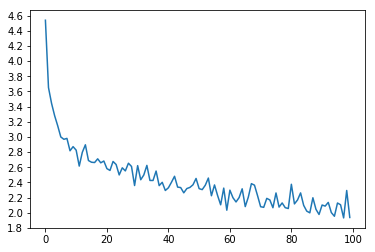

In [84]:
run_training(encoder, decoder, n_iters, print_every=100)

In [85]:
evaluate_randomly(encoder, decoder)

> вы заблудились, да ?
= you re lost, aren t you ?
< you are you ?

> я не силён .
= i m not strong .
< i m not a child .

> мне жаль, что ты проиграл .
= i m sorry you lost .
< i m glad i did you .

> я беру это .
= i m taking this one .
< i m going to go .

> я даже не устала .
= i m not even tired .
< i m not going to help .

> ты для этого слишком мал .
= you re too young for that .
< you re too old .

> они приезжают .
= they re coming .
< they re rich .

> я так же силён, как и раньше .
= i m as strong as before .
< i m so tired of his own .

> ты врач .
= you re the doctor .
< you re a fraud .

> я рад, что ты не пострадал .
= i m glad you didn t get injured .
< i m glad you asked that .



/home/alexey.kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


input = я очень осторожна .
output = i m very proud .
input = они всё ещё живут со своими родителями .
output = they re still doing this hope .


/home/alexey.kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


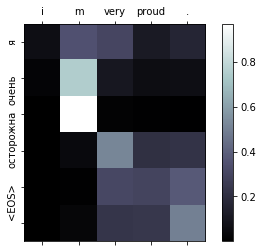

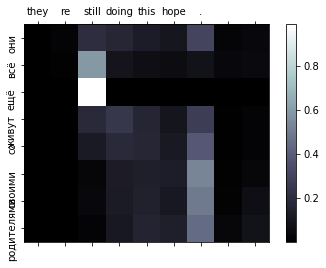

In [86]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_yticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    attentions = torch.cat(attentions).squeeze().cpu()
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("я очень осторожна .")
evaluateAndShowAttention("они всё ещё живут со своими родителями .")